In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc

In [2]:
#this is used to reduce the memory usage of the dataframe 
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
#Read the csv 
new_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    """
    Parameters
    -----------
    df : input dataframe 
    
    Return 
    ----------
    dataframe with column authorized_flag and category_1 ,mapped to either 1 or 0 """
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [4]:
%%time
def read_data(input_file):
    #change the column type to date type
    #calculate the elapsed time 
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('../input/elo-merchant-category-recommendation/train.csv')
test = read_data('../input/elo-merchant-category-recommendation/test.csv')

#take out the target column in the training data 
target = train['target']
del train['target']
gc.collect()

CPU times: user 1.74 s, sys: 12 ms, total: 1.75 s
Wall time: 1.78 s


## **Feature Engineering**

In [5]:
%%time
#create one-hot-encoding dataframe for category_2 and category_3
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

#reduce memory usage
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}

#groupby ohe dataframe by card_id
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]
gc.collect()

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)
CPU times: user 21 s, sys: 6.46 s, total: 27.5 s
Wall time: 27.5 s


In [6]:
%%time
#create purchase month
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month
gc.collect()

CPU times: user 1.77 s, sys: 4 ms, total: 1.78 s
Wall time: 1.78 s


In [7]:
%%time
def aggregate_transactions(history):
    '''
    Parameters 
    -----------
    history: historical transaction of dataframe
    
    output:
    ----------
    dataframe groupby card_id and aggregated on multiple function
    '''
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    #groupby card id 
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    #merge the two dataframe together 
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

gc.collect()

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 73.8 ms


In [8]:
%%time
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
gc.collect()
history[:5].head()


CPU times: user 55 s, sys: 80 ms, total: 55.1 s
Wall time: 55 s


In [9]:
history[:5].head()

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-11,0
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-2,0
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-8,0
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-7,-1
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-6,-4


In [10]:
%%time
#authorized transaction
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
gc.collect()

CPU times: user 2min 39s, sys: 4.13 s, total: 2min 43s
Wall time: 2min 43s


In [11]:
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-12,0
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-5,0
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-13,0
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-9,0
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-5,0


In [12]:
%%time
#doing the same thing for the new transaction
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

gc.collect()

CPU times: user 54.7 s, sys: 88 ms, total: 54.8 s
Wall time: 54.7 s


In [13]:
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2,2
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1,2
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1,2
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1,2


In [14]:
%%time
def aggregate_per_month(history):
    '''
    Parameter:
    ----------
    history transaction dataframe
    
    Output:
    ---------
    Create a new dataframe aggregated per month
    order : groupby card_id + month_lag ----> groupby card_id 
    '''
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }
    #group by and create new column
    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)
    
    #secondary group by card_id
    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]
gc.collect()

CPU times: user 2.97 s, sys: 0 ns, total: 2.97 s
Wall time: 2.98 s


In [15]:
%%time
#merge all the dataframe together
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
gc.collect()

Train Shape: (201917, 139)
Test Shape: (123623, 139)
CPU times: user 3.62 s, sys: 0 ns, total: 3.62 s
Wall time: 3.63 s


In [16]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,...,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_sum,authorized_flag_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.480384,9.538462,12.0,7.0,1.664101,14254523.0,1.500131e+09,1.514385e+09,-7.0,...,0.0,0.0,0.000000,3.478261,4.0,3.0,0.510754,4742309.0,1.520259e+09,1.525001e+09,1.0,2.0,-4.500000,1.870829,2.166667,1.169045,-1.428621,0.882324,-0.637972,0.119344,-0.664760,0.118497,-0.608962,0.127612,0.051078,0.050203,2.166667,1.169045,0.666667,0.816497,0.319444,0.423007,0.166667,0.408248,0.5,0.547723,0.269338,0.312603,247.0,0.950000
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,2.0,0.181818,0.818182,0.0,0.0,0.0,0.0,0.000000,0.363636,0.636364,9.0,9.0,2.0,2.0,9.0,-1.122886,-0.102081,1.942838,-0.740897,0.785906,42.0,3.818182,10.0,1.0,3.487641,8.545455,12.0,3.0,2.696799,25890841.0,1.488576e+09,1.514467e+09,-10.0,...,1.0,1.0,0.000000,2.500000,3.0,2.0,0.547723,4887632.0,1.517505e+09,1.522393e+09,1.0,2.0,-5.333333,3.326660,1.833333,1.602082,-0.187148,0.759414,-0.148523,0.438508,-0.292969,0.471576,0.154320,0.970537,0.535838,0.757790,1.833333,1.602082,7.000000,7.641989,4.033333,3.522310,3.500000,3.728270,5.0,4.289522,1.781853,2.519921,339.0,0.968571
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-1.338967,-0.669484,-0.637515,-0.701453,0.045211,0.0,0.000000,0.0,0.0,0.000000,3.000000,4.0,2.0,1.414214,4922885.0,1.487878e+09,1.492801e+09,-12.0,...,0.0,0.0,NaN,4.000000,4.0,4.0,NaN,0.0,1.524937e+09,1.524937e+09,2.0,2.0,-11.000000,1.414214,1.000000,0.000000,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,41.0,0.953488
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-1.0,0.755929,3.714286,4.0,3.0,0.487950,3625505.0,1.520424e+09,1.524049e+09,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.000000
4,2017-11-01,C_ID_cdbd2

In [17]:
# train.dropna(inplace = True)
# test.dropna(inplace = True)

In [18]:
#exclude the card_id and first_active month in the features 
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#create a list of categorical features 
categorical_feats = [c for c in features if 'feature_' in c]

In [19]:
#perform standardscaler for the train and test dataset 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_scaled = sc.fit_transform(train[features])
test_scaled = sc.fit_transform(test[features])
train_df = pd.DataFrame(train_scaled,columns = train[features].columns)
test_df = pd.DataFrame(test_scaled,columns = test[features].columns)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int16, float16, float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int16, float16, float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int16, float16, float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int16, float16, float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
train_df['card_id'] = train['card_id']
test_df['card_id'] = test['card_id']
train_df['first_active_month'] = train['first_active_month']
test_df['first_active_month'] = test['first_active_month']

train = train_df
test = test_df

In [21]:
train.shape

(201917, 139)

## LightGBM

In [22]:
#lightgbm configuration
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

In [23]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73666	valid_1's rmse: 3.79922
[200]	training's rmse: 3.6746	valid_1's rmse: 3.75807
[300]	training's rmse: 3.63172	valid_1's rmse: 3.73603
[400]	training's rmse: 3.59836	valid_1's rmse: 3.72298
[500]	training's rmse: 3.57074	valid_1's rmse: 3.71452
[600]	training's rmse: 3.54669	valid_1's rmse: 3.70827
[700]	training's rmse: 3.52651	valid_1's rmse: 3.70381
[800]	training's rmse: 3.50848	valid_1's rmse: 3.70012
[900]	training's rmse: 3.49183	valid_1's rmse: 3.69673
[1000]	training's rmse: 3.47636	valid_1's rmse: 3.69455
[1100]	training's rmse: 3.46231	valid_1's rmse: 3.69266
[1200]	training's rmse: 3.44915	valid_1's rmse: 3.6911
[1300]	training's rmse: 3.4367	valid_1's rmse: 3.68997
[1400]	training's rmse: 3.42506	valid_1's rmse: 3.68897
[1500]	training's rmse: 3.41383	valid_1's rmse: 3.6879
[1600]	training's rmse: 3.40277	valid_1's rmse: 3.68725
[1700]	training's rmse: 3.39218	valid_1's rmse: 3.6871

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75309	valid_1's rmse: 3.72797
[200]	training's rmse: 3.6891	valid_1's rmse: 3.6913
[300]	training's rmse: 3.64477	valid_1's rmse: 3.67354
[400]	training's rmse: 3.6108	valid_1's rmse: 3.6621
[500]	training's rmse: 3.58237	valid_1's rmse: 3.65544
[600]	training's rmse: 3.55799	valid_1's rmse: 3.64997
[700]	training's rmse: 3.53733	valid_1's rmse: 3.64543
[800]	training's rmse: 3.5192	valid_1's rmse: 3.64227
[900]	training's rmse: 3.50284	valid_1's rmse: 3.63969
[1000]	training's rmse: 3.48809	valid_1's rmse: 3.63751
[1100]	training's rmse: 3.47411	valid_1's rmse: 3.63587
[1200]	training's rmse: 3.46099	valid_1's rmse: 3.63441
[1300]	training's rmse: 3.44883	valid_1's rmse: 3.63349
[1400]	training's rmse: 3.43694	valid_1's rmse: 3.63245
[1500]	training's rmse: 3.42551	valid_1's rmse: 3.63172
[1600]	training's rmse: 3.41458	valid_1's rmse: 3.63095
[1700]	training's rmse: 3.40416	valid_1's rmse: 3.63062

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75738	valid_1's rmse: 3.70452
[200]	training's rmse: 3.69266	valid_1's rmse: 3.66998
[300]	training's rmse: 3.64851	valid_1's rmse: 3.6518
[400]	training's rmse: 3.61409	valid_1's rmse: 3.63983
[500]	training's rmse: 3.5869	valid_1's rmse: 3.63262
[600]	training's rmse: 3.5631	valid_1's rmse: 3.62694
[700]	training's rmse: 3.54215	valid_1's rmse: 3.62272
[800]	training's rmse: 3.52424	valid_1's rmse: 3.62012
[900]	training's rmse: 3.50729	valid_1's rmse: 3.61762
[1000]	training's rmse: 3.4922	valid_1's rmse: 3.61582
[1100]	training's rmse: 3.47802	valid_1's rmse: 3.61447
[1200]	training's rmse: 3.46409	valid_1's rmse: 3.61267
[1300]	training's rmse: 3.45117	valid_1's rmse: 3.61175
[1400]	training's rmse: 3.43928	valid_1's rmse: 3.61091
[1500]	training's rmse: 3.42767	valid_1's rmse: 3.61055
[1600]	training's rmse: 3.41673	valid_1's rmse: 3.61041
[1700]	training's rmse: 3.40556	valid_1's rmse: 3.6101

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71137	valid_1's rmse: 3.8955
[200]	training's rmse: 3.64944	valid_1's rmse: 3.85323
[300]	training's rmse: 3.60572	valid_1's rmse: 3.83033
[400]	training's rmse: 3.57082	valid_1's rmse: 3.81839
[500]	training's rmse: 3.54265	valid_1's rmse: 3.81107
[600]	training's rmse: 3.51834	valid_1's rmse: 3.8065
[700]	training's rmse: 3.49729	valid_1's rmse: 3.80313
[800]	training's rmse: 3.4789	valid_1's rmse: 3.80014
[900]	training's rmse: 3.46253	valid_1's rmse: 3.79812
[1000]	training's rmse: 3.44662	valid_1's rmse: 3.79631
[1100]	training's rmse: 3.43241	valid_1's rmse: 3.79497
[1200]	training's rmse: 3.41873	valid_1's rmse: 3.79336
[1300]	training's rmse: 3.40578	valid_1's rmse: 3.79243
[1400]	training's rmse: 3.39369	valid_1's rmse: 3.79183
[1500]	training's rmse: 3.38259	valid_1's rmse: 3.79127
[1600]	training's rmse: 3.37162	valid_1's rmse: 3.79067
[1700]	training's rmse: 3.36131	valid_1's rmse: 3.790

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75349	valid_1's rmse: 3.71769
[200]	training's rmse: 3.68788	valid_1's rmse: 3.68373
[300]	training's rmse: 3.64303	valid_1's rmse: 3.66802
[400]	training's rmse: 3.60842	valid_1's rmse: 3.65713
[500]	training's rmse: 3.58011	valid_1's rmse: 3.65051
[600]	training's rmse: 3.55642	valid_1's rmse: 3.64606
[700]	training's rmse: 3.53597	valid_1's rmse: 3.64229
[800]	training's rmse: 3.51834	valid_1's rmse: 3.6393
[900]	training's rmse: 3.50125	valid_1's rmse: 3.63725
[1000]	training's rmse: 3.48631	valid_1's rmse: 3.6354
[1100]	training's rmse: 3.47246	valid_1's rmse: 3.63396
[1200]	training's rmse: 3.45909	valid_1's rmse: 3.63274
[1300]	training's rmse: 3.44626	valid_1's rmse: 3.63182
[1400]	training's rmse: 3.43445	valid_1's rmse: 3.63099
[1500]	training's rmse: 3.42316	valid_1's rmse: 3.63023
[1600]	training's rmse: 3.41281	valid_1's rmse: 3.62965
[1700]	training's rmse: 3.40256	valid_1's rmse: 3.62

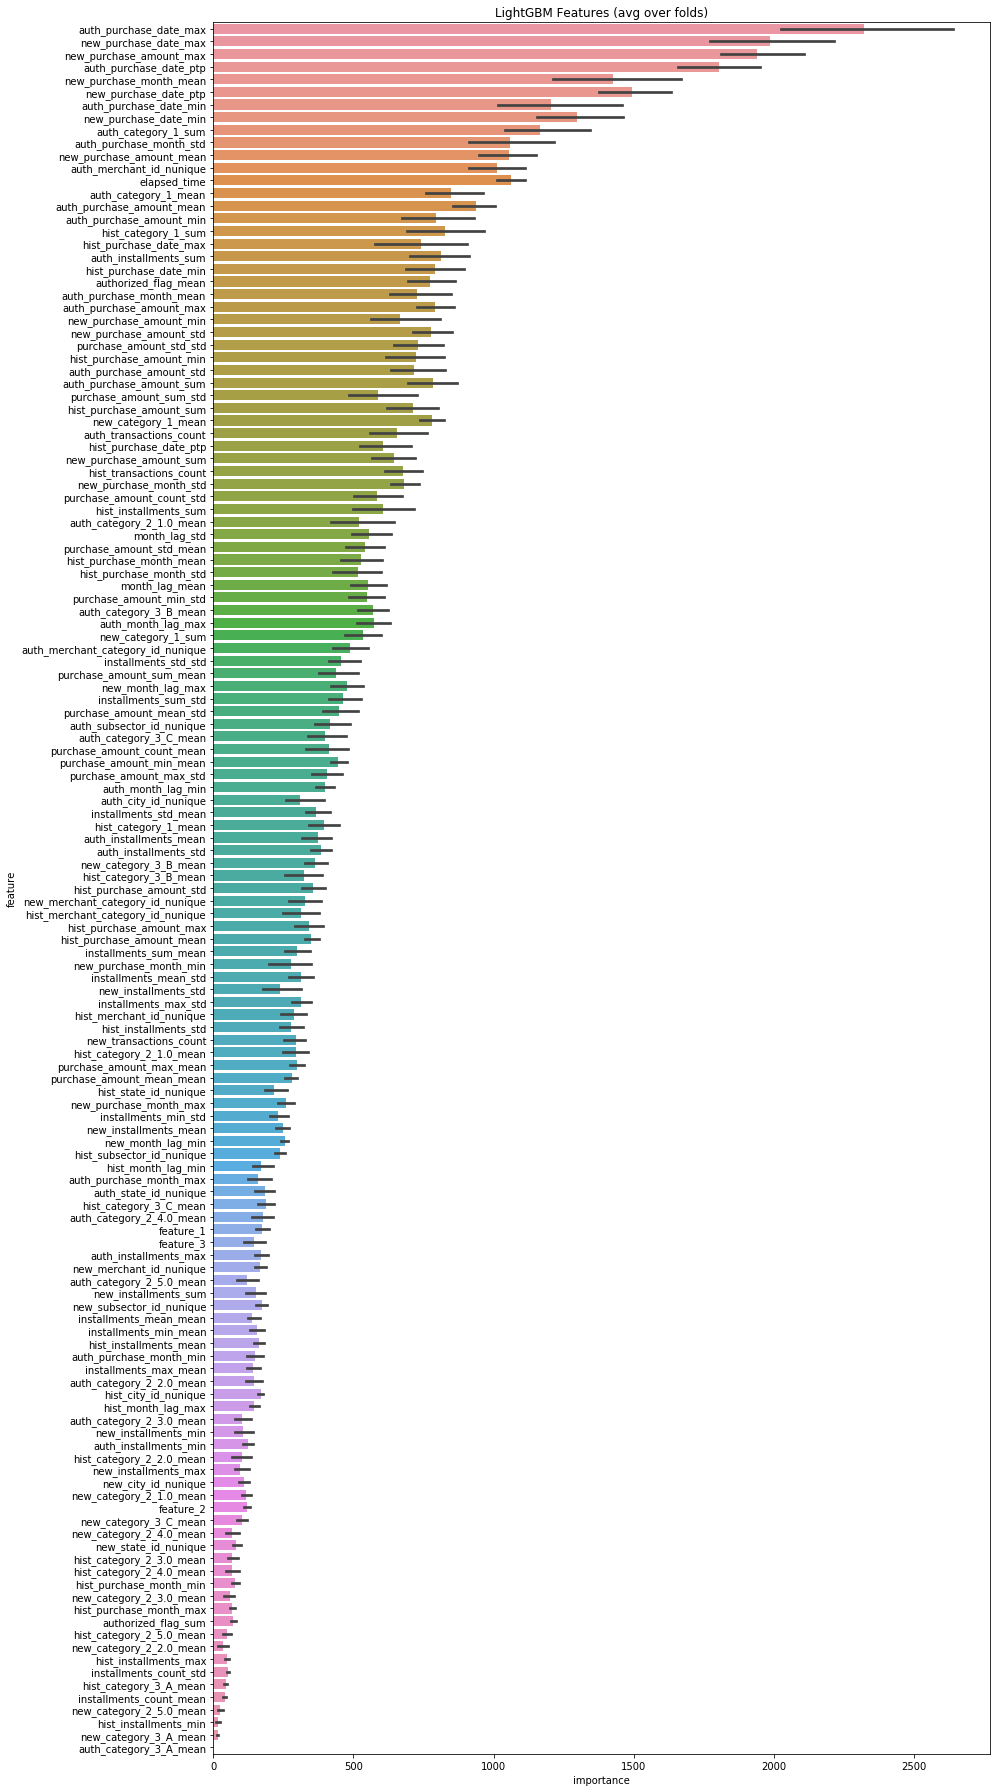

In [24]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

## LightGBM-1 with Repeated kfold approach

#### RepeatedKFold repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

In [25]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [26]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.6729	valid_1's rmse: 3.74639
[200]	training's rmse: 3.59244	valid_1's rmse: 3.71922
[300]	training's rmse: 3.53792	valid_1's rmse: 3.70765
[400]	training's rmse: 3.49807	valid_1's rmse: 3.70164
[500]	training's rmse: 3.46569	valid_1's rmse: 3.69776
[600]	training's rmse: 3.43817	valid_1's rmse: 3.69583
[700]	training's rmse: 3.41359	valid_1's rmse: 3.69485
[800]	training's rmse: 3.39015	valid_1's rmse: 3.6948
[900]	training's rmse: 3.36891	valid_1's rmse: 3.69521
Early stopping, best iteration is:
[823]	training's rmse: 3.3851	valid_1's rmse: 3.69462
fold n°1


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.70771	valid_1's rmse: 3.60908
[200]	training's rmse: 3.63094	valid_1's rmse: 3.57686
[300]	training's rmse: 3.5789	valid_1's rmse: 3.56366
[400]	training's rmse: 3.53962	valid_1's rmse: 3.55586
[500]	training's rmse: 3.5081	valid_1's rmse: 3.55089
[600]	training's rmse: 3.48015	valid_1's rmse: 3.54712
[700]	training's rmse: 3.45586	valid_1's rmse: 3.54539
[800]	training's rmse: 3.43327	valid_1's rmse: 3.54372
[900]	training's rmse: 3.41243	valid_1's rmse: 3.54336
[1000]	training's rmse: 3.39263	valid_1's rmse: 3.54271
[1100]	training's rmse: 3.37361	valid_1's rmse: 3.5422
Early stopping, best iteration is:
[1075]	training's rmse: 3.37835	valid_1's rmse: 3.54188
fold n°2


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.63828	valid_1's rmse: 3.89423
[200]	training's rmse: 3.56003	valid_1's rmse: 3.86328
[300]	training's rmse: 3.50818	valid_1's rmse: 3.8494
[400]	training's rmse: 3.4696	valid_1's rmse: 3.84161
[500]	training's rmse: 3.43755	valid_1's rmse: 3.83688
[600]	training's rmse: 3.40907	valid_1's rmse: 3.83416
[700]	training's rmse: 3.38452	valid_1's rmse: 3.83258
[800]	training's rmse: 3.36152	valid_1's rmse: 3.83241
Early stopping, best iteration is:
[751]	training's rmse: 3.37303	valid_1's rmse: 3.83194
fold n°3


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68096	valid_1's rmse: 3.72238
[200]	training's rmse: 3.60191	valid_1's rmse: 3.69178
[300]	training's rmse: 3.54906	valid_1's rmse: 3.68146
[400]	training's rmse: 3.51034	valid_1's rmse: 3.67503
[500]	training's rmse: 3.47906	valid_1's rmse: 3.67096
[600]	training's rmse: 3.45126	valid_1's rmse: 3.66739
[700]	training's rmse: 3.42601	valid_1's rmse: 3.66481
[800]	training's rmse: 3.40286	valid_1's rmse: 3.6634
[900]	training's rmse: 3.38149	valid_1's rmse: 3.66194
[1000]	training's rmse: 3.36141	valid_1's rmse: 3.66152
[1100]	training's rmse: 3.34376	valid_1's rmse: 3.66138
Early stopping, best iteration is:
[1066]	training's rmse: 3.35019	valid_1's rmse: 3.66109
fold n°4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68952	valid_1's rmse: 3.68879
[200]	training's rmse: 3.61151	valid_1's rmse: 3.65406
[300]	training's rmse: 3.55902	valid_1's rmse: 3.63847
[400]	training's rmse: 3.51893	valid_1's rmse: 3.62961
[500]	training's rmse: 3.4873	valid_1's rmse: 3.62407
[600]	training's rmse: 3.46082	valid_1's rmse: 3.61985
[700]	training's rmse: 3.43623	valid_1's rmse: 3.61706
[800]	training's rmse: 3.41446	valid_1's rmse: 3.61581
[900]	training's rmse: 3.39434	valid_1's rmse: 3.61512
[1000]	training's rmse: 3.37498	valid_1's rmse: 3.61461
[1100]	training's rmse: 3.35772	valid_1's rmse: 3.61397
[1200]	training's rmse: 3.33923	valid_1's rmse: 3.61361
[1300]	training's rmse: 3.32153	valid_1's rmse: 3.61337
[1400]	training's rmse: 3.30524	valid_1's rmse: 3.61281
[1500]	training's rmse: 3.29009	valid_1's rmse: 3.613
Early stopping, best iteration is:
[1413]	training's rmse: 3.30343	valid_1's rmse: 3.61271
fold n°5


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66169	valid_1's rmse: 3.78401
[200]	training's rmse: 3.58139	valid_1's rmse: 3.75703
[300]	training's rmse: 3.5293	valid_1's rmse: 3.74737
[400]	training's rmse: 3.48927	valid_1's rmse: 3.74132
[500]	training's rmse: 3.45616	valid_1's rmse: 3.73721
[600]	training's rmse: 3.42865	valid_1's rmse: 3.73509
[700]	training's rmse: 3.40176	valid_1's rmse: 3.73298
[800]	training's rmse: 3.37927	valid_1's rmse: 3.73191
[900]	training's rmse: 3.3586	valid_1's rmse: 3.7319
[1000]	training's rmse: 3.33891	valid_1's rmse: 3.73127
[1100]	training's rmse: 3.32164	valid_1's rmse: 3.73088
[1200]	training's rmse: 3.30406	valid_1's rmse: 3.73049
[1300]	training's rmse: 3.28665	valid_1's rmse: 3.73001
[1400]	training's rmse: 3.27104	valid_1's rmse: 3.72977
[1500]	training's rmse: 3.25543	valid_1's rmse: 3.72959
[1600]	training's rmse: 3.23991	valid_1's rmse: 3.72955
Early stopping, best iteration is:
[1531]	training's 

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67913	valid_1's rmse: 3.72357
[200]	training's rmse: 3.59962	valid_1's rmse: 3.69537
[300]	training's rmse: 3.54772	valid_1's rmse: 3.68485
[400]	training's rmse: 3.50855	valid_1's rmse: 3.67852
[500]	training's rmse: 3.47692	valid_1's rmse: 3.67364
[600]	training's rmse: 3.45011	valid_1's rmse: 3.67053
[700]	training's rmse: 3.42556	valid_1's rmse: 3.66826
[800]	training's rmse: 3.40296	valid_1's rmse: 3.66745
[900]	training's rmse: 3.38233	valid_1's rmse: 3.66657
[1000]	training's rmse: 3.36245	valid_1's rmse: 3.66593
[1100]	training's rmse: 3.34344	valid_1's rmse: 3.66524
[1200]	training's rmse: 3.32627	valid_1's rmse: 3.66458
[1300]	training's rmse: 3.30956	valid_1's rmse: 3.66459
Early stopping, best iteration is:
[1281]	training's rmse: 3.31278	valid_1's rmse: 3.66437
fold n°7


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67603	valid_1's rmse: 3.75183
[200]	training's rmse: 3.59869	valid_1's rmse: 3.71476
[300]	training's rmse: 3.5474	valid_1's rmse: 3.69938
[400]	training's rmse: 3.50925	valid_1's rmse: 3.69229
[500]	training's rmse: 3.47767	valid_1's rmse: 3.68719
[600]	training's rmse: 3.44972	valid_1's rmse: 3.68457
[700]	training's rmse: 3.42508	valid_1's rmse: 3.6829
[800]	training's rmse: 3.40224	valid_1's rmse: 3.68115
[900]	training's rmse: 3.38163	valid_1's rmse: 3.68046
[1000]	training's rmse: 3.36225	valid_1's rmse: 3.68013
[1100]	training's rmse: 3.34311	valid_1's rmse: 3.67969
[1200]	training's rmse: 3.32511	valid_1's rmse: 3.6793
[1300]	training's rmse: 3.30782	valid_1's rmse: 3.67906
[1400]	training's rmse: 3.29199	valid_1's rmse: 3.67907
Early stopping, best iteration is:
[1351]	training's rmse: 3.29966	valid_1's rmse: 3.67879
fold n°8


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68257	valid_1's rmse: 3.71178
[200]	training's rmse: 3.60262	valid_1's rmse: 3.68215
[300]	training's rmse: 3.54984	valid_1's rmse: 3.6697
[400]	training's rmse: 3.50963	valid_1's rmse: 3.66448
[500]	training's rmse: 3.47731	valid_1's rmse: 3.66123
[600]	training's rmse: 3.44855	valid_1's rmse: 3.65865
[700]	training's rmse: 3.42275	valid_1's rmse: 3.6576
[800]	training's rmse: 3.40033	valid_1's rmse: 3.65655
[900]	training's rmse: 3.37828	valid_1's rmse: 3.65668
Early stopping, best iteration is:
[817]	training's rmse: 3.3963	valid_1's rmse: 3.65634
fold n°9


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.69147	valid_1's rmse: 3.68508
[200]	training's rmse: 3.61375	valid_1's rmse: 3.64881
[300]	training's rmse: 3.56085	valid_1's rmse: 3.63347
[400]	training's rmse: 3.52226	valid_1's rmse: 3.62459
[500]	training's rmse: 3.49047	valid_1's rmse: 3.61925
[600]	training's rmse: 3.46389	valid_1's rmse: 3.61544
[700]	training's rmse: 3.43954	valid_1's rmse: 3.61314
[800]	training's rmse: 3.41705	valid_1's rmse: 3.61112
[900]	training's rmse: 3.39703	valid_1's rmse: 3.61024
[1000]	training's rmse: 3.37732	valid_1's rmse: 3.60921
[1100]	training's rmse: 3.35937	valid_1's rmse: 3.60831
[1200]	training's rmse: 3.34238	valid_1's rmse: 3.6075
[1300]	training's rmse: 3.32527	valid_1's rmse: 3.60715
[1400]	training's rmse: 3.30905	valid_1's rmse: 3.6072
Early stopping, best iteration is:
[1358]	training's rmse: 3.31556	valid_1's rmse: 3.60708
CV score: 3.66740 


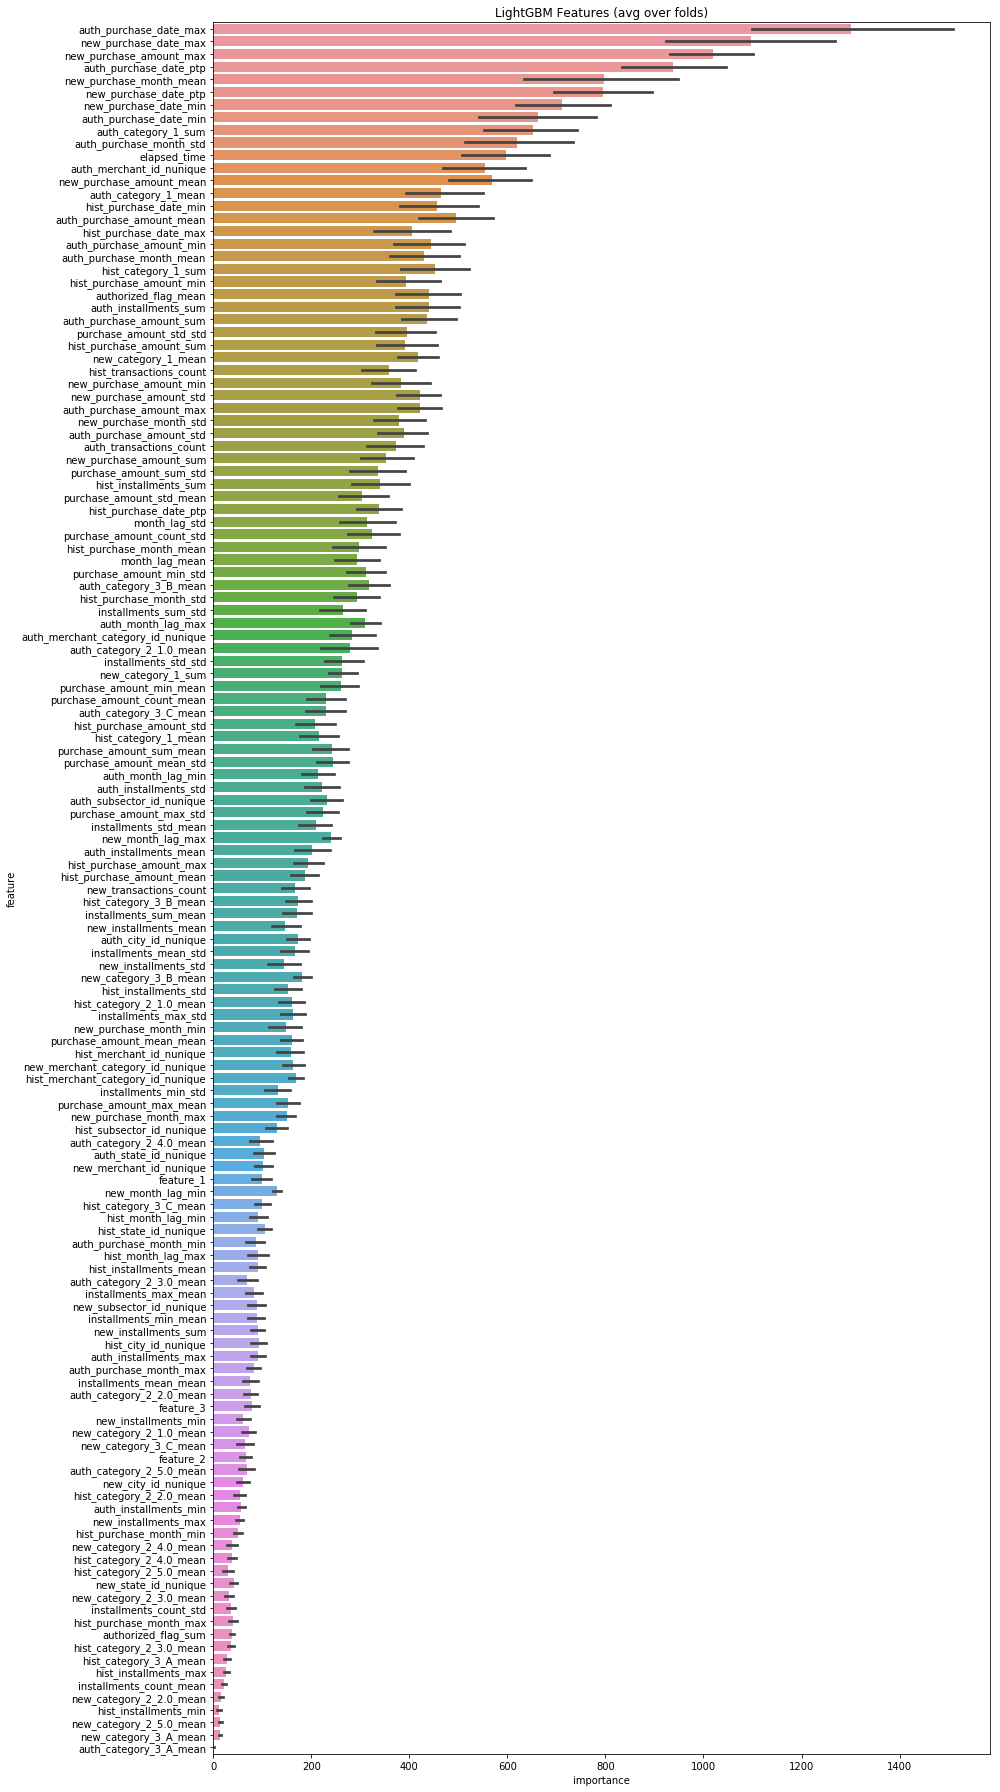

In [27]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [28]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit_lgb.csv", index=False)

sub_df1 = pd.DataFrame({"card_id":test["card_id"].values})
sub_df1["target"] = predictions_lgb
sub_df1.to_csv("submit_lgb1.csv", index=False)

## Stacking

In [29]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


3.6656315774947763

In [30]:
sample_submission = pd.read_csv('../input/elo-merchant-category-recommendation/sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('Bayesian_Ridge_Stacking.csv', index=False)

In [31]:
sample_submission = pd.read_csv('../input/elo-merchant-category-recommendation/sample_submission.csv')
sample1 = pd.read_csv("../input/elo-blending/3.695.csv")
sample2 = pd.read_csv("../input/elo-blending/combining_submission (1).csv")
sample_submission['target'] = predictions * 0.5 + predictions_lgb * 0.5
sample_submission.to_csv("Blend1.csv", index = False)
sample_submission['target'] = sample_submission['target'] * 0.2 + sample1['target'] * 0.2 + sample2['target'] * 0.6
sample_submission.to_csv('Blend2.csv', index=False)